In [46]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
# Reads in the data, ignoring the first row (header) and first column (index).
df = pd.read_csv('gdrive/My Drive/diabetes.csv')
numpyArray = df.to_numpy()

In [49]:
#Separates the class label from the observable data to form matrices Y and X, respectively.

X = np.delete(numpyArray, 0, axis=1)
Y = np.delete(numpyArray, slice(1, None, 1), axis=1)

In [50]:
# Standardizes the features.
mean = np.mean(X, axis=0)
std = np.std(X, axis=0, ddof=1)

std_X = (X-mean)/std

In [51]:
def PCA(X_data, components = 2, whiten=False):
  covariance_matrix = np.cov(X_data.T)

  eigenvals, eigenvecs = np.linalg.eig(covariance_matrix)

  eigenvecs = eigenvecs.T

  eigenvecs = np.real(eigenvecs)

  indices_of_sorted_eigenvecs = np.argsort(eigenvals)[::-1]

  eigenvals = eigenvals[indices_of_sorted_eigenvecs]
  eigenvecs = eigenvecs[indices_of_sorted_eigenvecs]

  pca_components = eigenvecs[0:components]

  if(whiten):
    return np.dot(np.dot(np.diag(eigenvals[0:components]**(-1/2)), eigenvecs[0:components]), X_data.T).T
  else:
    return np.dot(X_data, pca_components.T)

In [52]:
def euclidean_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2)**2))

In [53]:
def manhatten_distance(x1, x2):
  return np.sum(np.abs(x1-x2))

In [54]:
path_to_img_sequence = 'scatterPlots/'
output_path = 'output/'
output_video_name = 'clustering.mp4'
output_video_path = output_path + output_video_name

In [55]:
def make_opencv_video():
    #Citation: https://www.youtube.com/watch?v=ZcqodhMuv4o
    #Used this tutorial as a reference to make the opencv video for the scatterplots
    
    paths = sorted(Path("scatterPlots/").iterdir(), key=os.path.getmtime)

    cv2_4_cc_code = cv2.VideoWriter_fourcc(*'mp4v')

    frame = cv2.imread(str(paths[0]))
    size = list(frame.shape)
    del size[2]
    size.reverse()

    video = cv2.VideoWriter(output_video_path, cv2_4_cc_code, 3, size)

    for i in range(len(paths)):
        video.write(cv2.imread(str(paths[i])))

    video.release()

In [56]:
def myKMeans(X, Y, k=2):

  # Reduce dimentionality to 3
  if(X.shape[1] > 3):
    X = PCA(X, components=3, whiten=False)
  
  # List of k centroids/means
  centroids = []

  #Seed random generator to 0
  np.random.seed(0)

  #Pick k random rows to be the initial centroids/means
  number_of_rows = X.shape[0]

  random_indices = np.random.choice(number_of_rows, 
                                    size=k, 
                                    replace=False)
  
  random_rows_selected = X[random_indices, :]

  # Add the three randomly selected centroids to the list of centroids
  for row in random_rows_selected:
    centroids.append(row)

  # Set the current centroids as the prev ones
  prev_centroids_positions = centroids

  #Initial change in the sum of the change in magnitude of the centroids is 1
  change_in_magnitude_of_centroids = 1
  
  #This keeps track of the number of iterations
  count = 0

  angle = 0

  #Keeps reclustering until the sum of the change in the magnitudes of the current and previous cluster means is less than 2^-23
  while(change_in_magnitude_of_centroids >= 2**-23):
    
    #Initially clusters is just an empty list
    clusters = []

    #Add k empty lists within clusters to represent each cluster within the whole set of clusters
    for i in range(0, k):
      clusters.append([])

    count += 1

    #For each point in our data find its euclidean distance from each of the k centroids and add it to the cluster that is associated with
    #the closest centroid
    for i in range(len(X)):
      distances_to_centroids = []

      for centroid in centroids:
        distances_to_centroids.append(euclidean_distance(X[i], centroid))
      
      shortest_distance_centroid_index = np.argmin(distances_to_centroids)

      clusters[shortest_distance_centroid_index].append(X[i])

    #Calculate the mean of each cluster after assigning all data points to a cluster
    cluster_means = []

    for cluster in clusters:
      cluster_means.append(np.mean(cluster, axis=0))
    
    #Colors that will represent the clusters, MAX IS k=7
    colors = ["blue", "red", "green", "yellow", "black", "purple", "orange"]

    purity = 0

    #Draw a scatter plot for the initial iteration
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    #Iterate through each set of clusters and find its associated output value and calculate the purity
    for i in range(len(clusters)):
      cluster = clusters[i]
      cluster = np.array(cluster)

      #Plots the data to the scatter plot for only the initial iteration
      x_vals = cluster[:,0]
      y_vals = cluster[:,1]
      z_vals = cluster[:,2]
      ax.scatter3D(x_vals, y_vals, z_vals, color = colors[i], marker='x')
      ax.scatter3D(centroids[i][0], centroids[i][1], centroids[i][2], color = colors[i], marker='o', s=200, edgecolors="black")

      #Stores the count of the occurence of each class in our data X
      classes = {}

      for value in np.unique(Y):
        classes[str(int(value))] = 0
      
      for j in range(len(cluster)):
        result = np.where(X == cluster[j])[0][0]

        classAssociation = int(Y[result])

        classes[str(classAssociation)] = classes[str(classAssociation)] + 1

      purity += ( (len(cluster) / len(X)) * (classes[max(classes, key=classes.get)] / len(cluster)) )

      plt.title("Iteration: " + str(count) + " Purity = " + str(purity), fontweight="bold", size=20)
      ax.view_init(30,angle)
      angle = (angle + 5) % 360 
      #plt.savefig(path_to_img_sequence + "plot_" + str(count))     ONLY RUN LOCALLY
    
    centroids = []

    for cluster in clusters:
      mean = np.mean(cluster, axis=0)
      centroids.append(mean)

    change_in_magnitude_of_centroids = np.linalg.norm(manhatten_distance(np.array(prev_centroids_positions), np.array(centroids)))

    prev_centroids_positions = centroids

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(projection='3d')

  for i in range(len(clusters)):
    cluster = clusters[i]
    cluster = np.array(cluster)

    x_vals = cluster[:,0]
    y_vals = cluster[:,1]
    z_vals = cluster[:,2]
    ax.scatter3D(x_vals, y_vals, z_vals, color = colors[i], marker='x')
    ax.scatter3D(centroids[i][0], centroids[i][1], centroids[i][2], color = colors[i], marker='o', s=200, edgecolors="black")

  plt.title("Iteration: " + str(count) + " Purity = " + str(purity), fontweight="bold", size=20)
  ax.view_init(30,angle)
  angle = (angle + 5) % 360
  #plt.savefig(path_to_img_sequence + "plot_" + str(count))     ONLY RUN LOCALLY

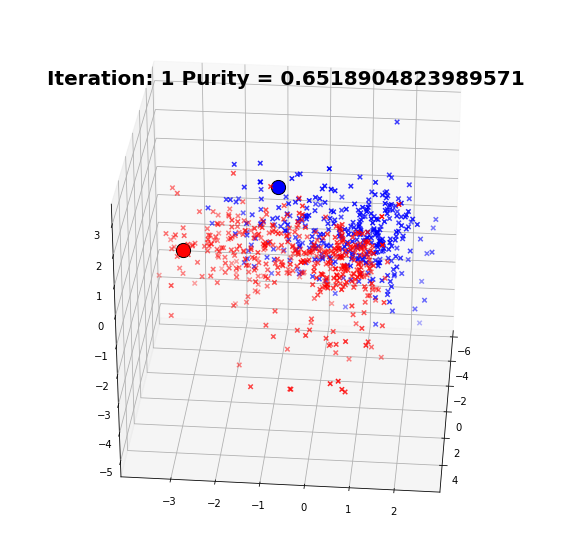

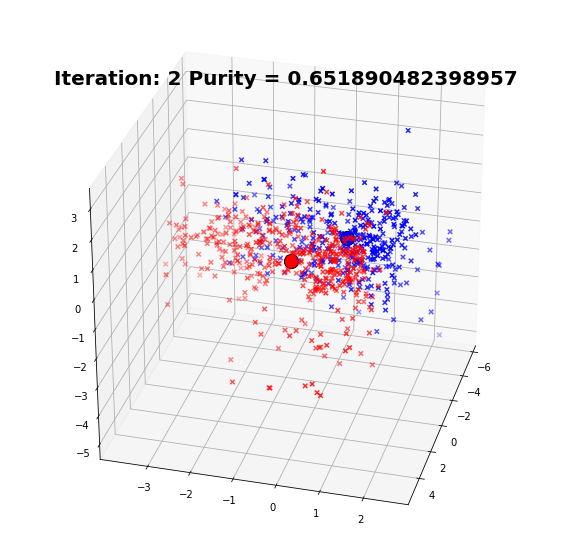

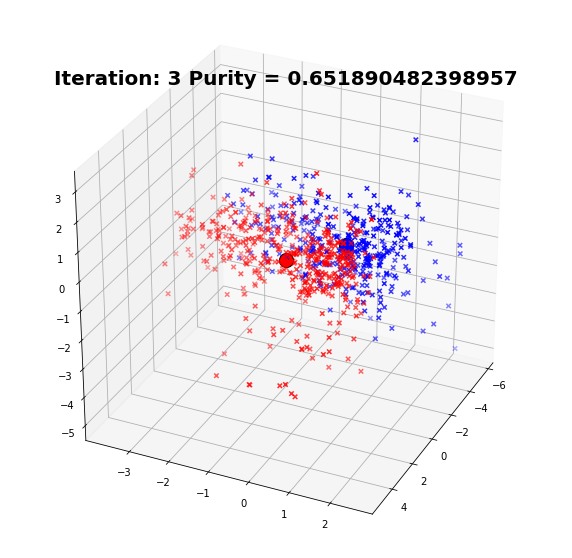

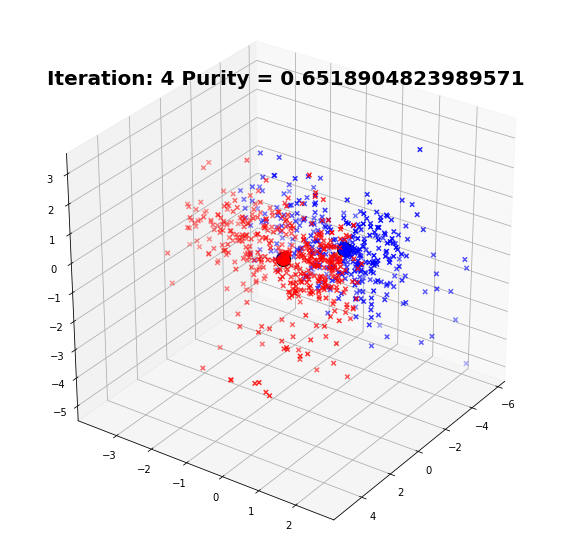

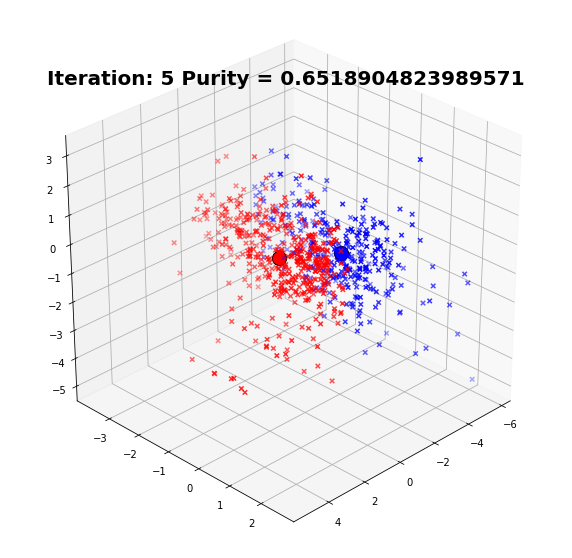

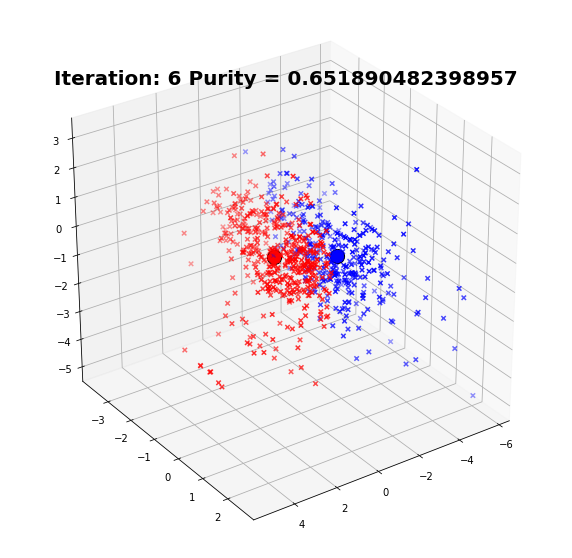

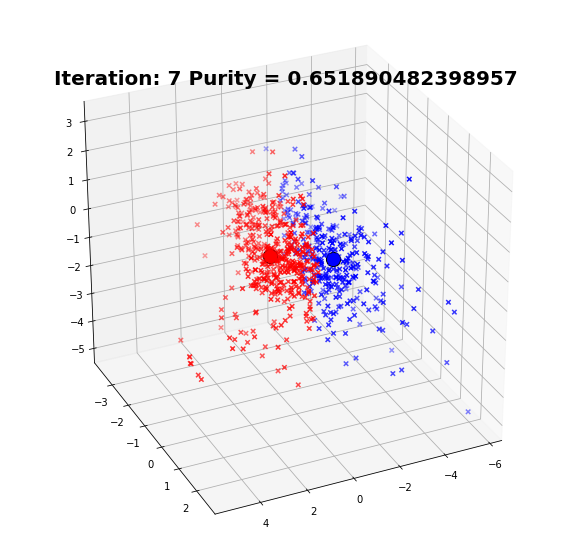

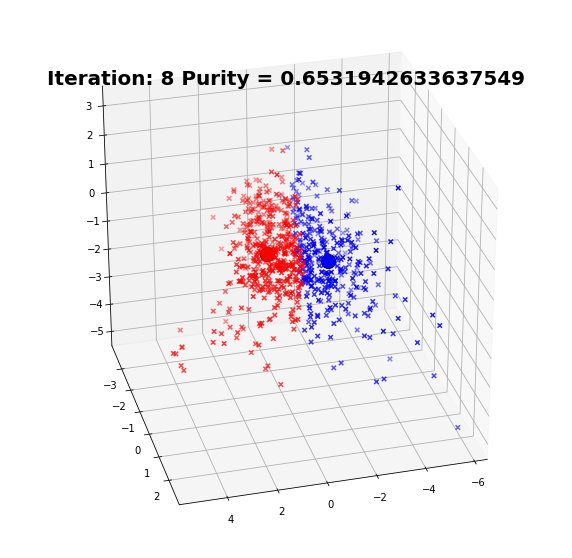

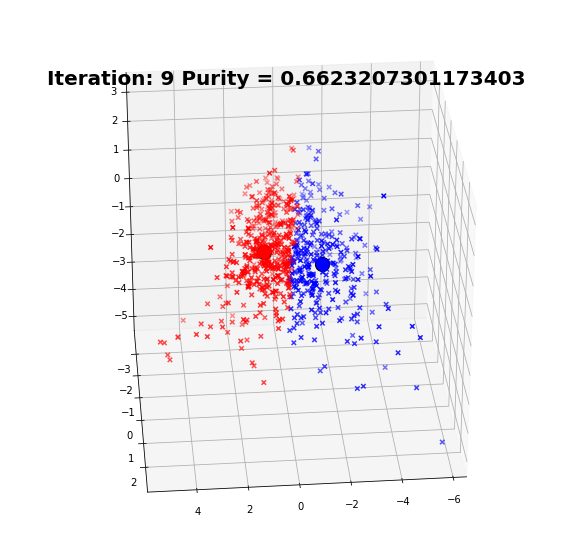

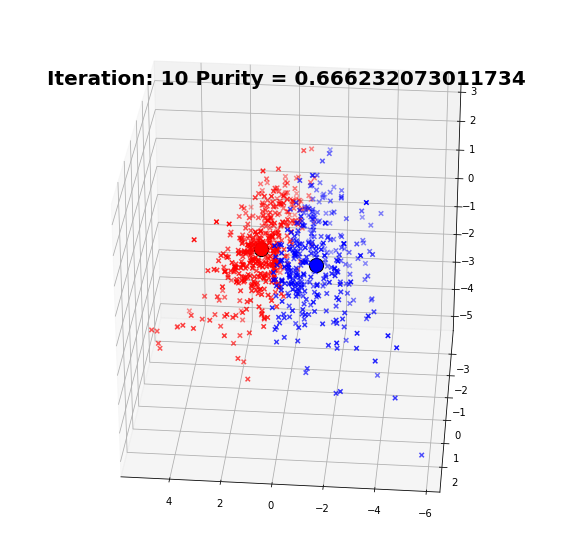

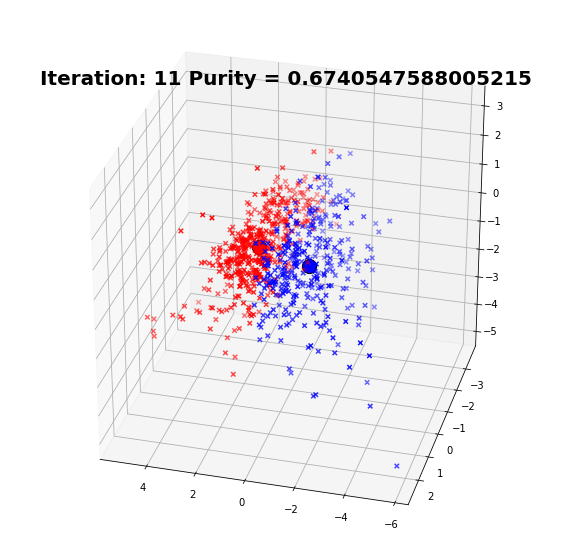

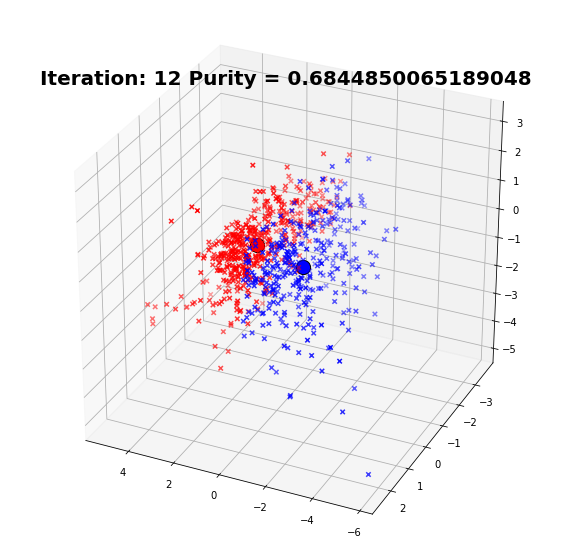

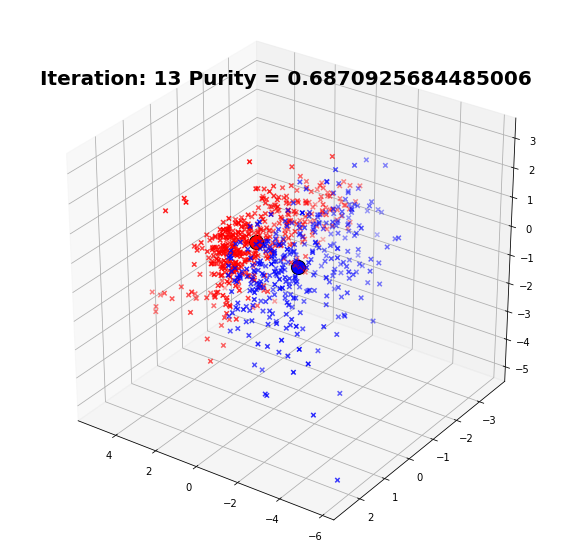

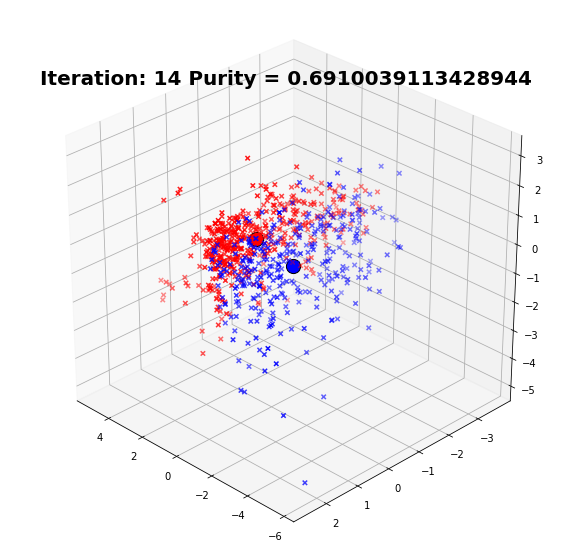

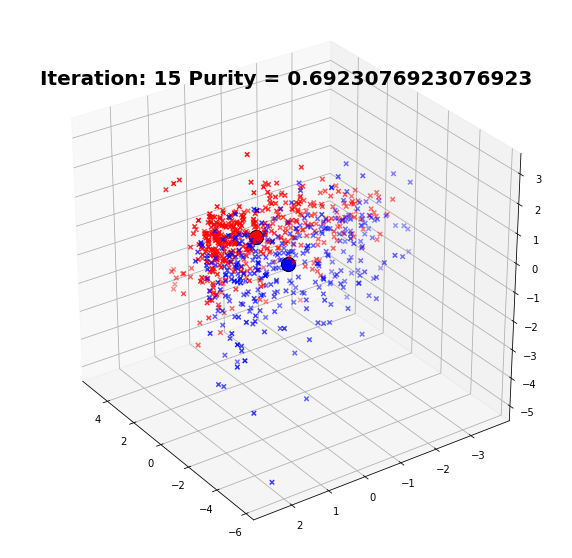

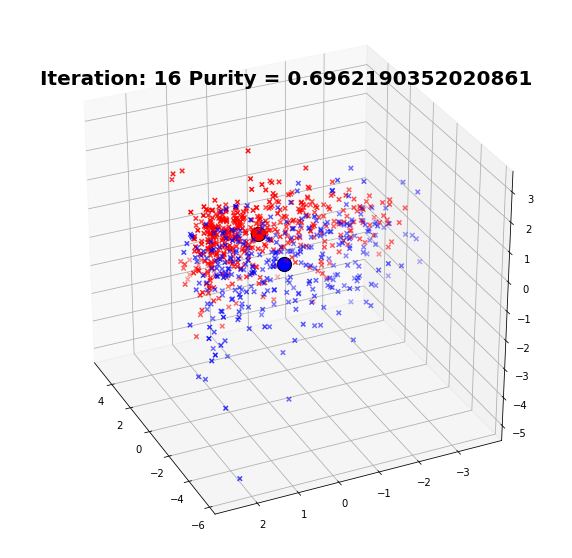

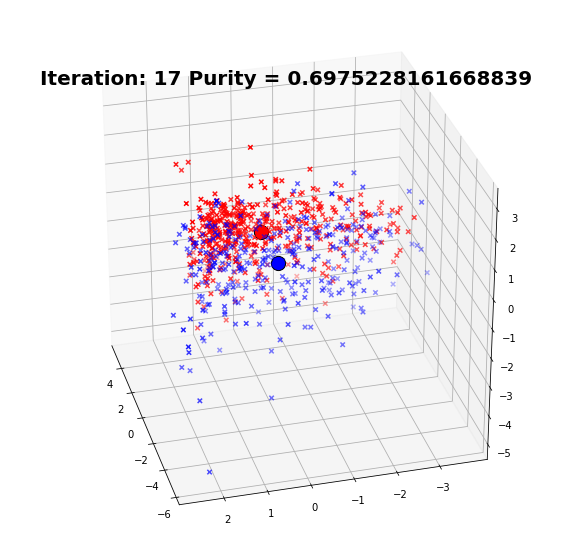

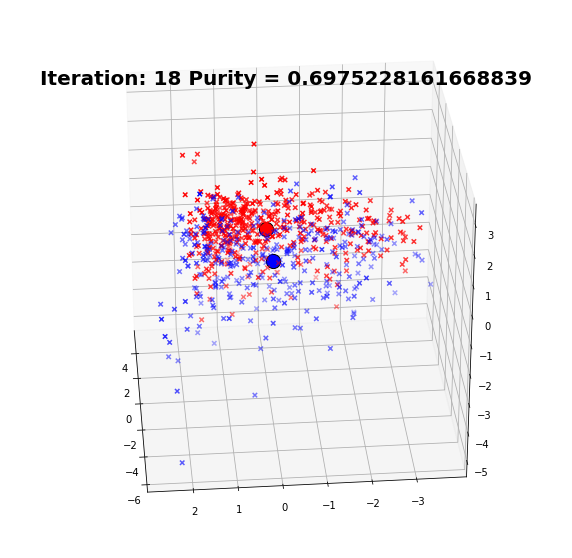

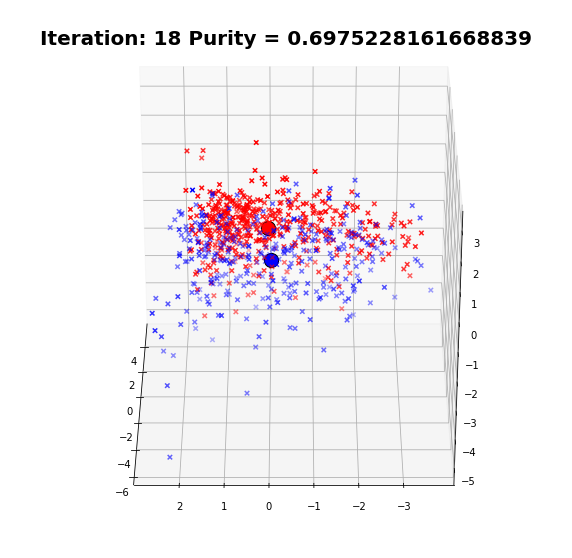

In [57]:
myKMeans(std_X, Y, k=2)

#This code below is only meant to be run locally and will not work when running on Google Colab. I generated the mp4 files which include the rotations of the various iterations of the scatter plots locally and am attaching them with my submission.
#make_opencv_video()